# Problem Description

We are required to construct a portfolio with SPY and a (ideal constant interest rate) Bond.

The lookback window length is N = 900 days, and predict a forward window of T = 100 days.

The goal is to maximize power utility $\mathbb{E}[\frac{W_T(\alpha_{1:T})^{\zeta}}{\zeta}]$, where $\zeta = 3$.

In [2]:
from typing import Any, List, Dict
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 0. Download Data

In [3]:
spy = yf.Ticker('SPY')
# data = spy.history(period='max')
df = spy.history(start='2016-01-01', end='2023-01-05')
df['Daily_Return'] = df['Close'].pct_change()
df.to_csv('spy.csv')


In [4]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily_Return
Date,,,,,,,,,
2016-01-04 00:00:00-05:00,170.425058,170.884076,168.809969,170.875580,222353500,0.0,0.0,0.0,NaN
2016-01-05 00:00:00-05:00,171.198638,171.623660,170.051088,171.164642,110845800,0.0,0.0,0.0,0.001692
2016-01-06 00:00:00-05:00,168.597494,170.059569,167.968470,169.005524,152112600,0.0,0.0,0.0,-0.012614
2016-01-07 00:00:00-05:00,166.038829,167.832419,164.559750,164.950775,213436100,0.0,0.0,0.0,-0.023992
2016-01-08 00:00:00-05:00,165.919872,166.480904,162.851217,163.140228,209817200,0.0,0.0,0.0,-0.010976


In [5]:
df.shape

(1764, 9)

## (a) Construct and backtest.
Plot PnL, annualized mean, std, sharpe ratio.

In [6]:
def compute_stats(df):
  df['Daily_Return'] = df['Close'].pct_change()

  # 定义窗口参数
  window = 900
  step = 100

  # 2. 计算滚动统计量
  # pandas 会将滚动计算的结果放在窗口的末尾
  df['Rolling_Mean'] = df['Daily_Return'].rolling(window=window).mean()
  df['Rolling_Std'] = df['Daily_Return'].rolling(window=window).std()

  # 丢弃 NaN 值，只保留有完整窗口 (900个数据点) 的结果
  df = df.dropna(subset=['Rolling_Mean', 'Rolling_Std'])
  # 筛选出每隔 step=100 的索引
  selection_indices = list(range(0, len(df), step)) # + [-1]
  # print(selection_indices)
  # 获取步长滚动的统计结果
  result_df = df.iloc[selection_indices, :][['Rolling_Mean', 'Rolling_Std']]
  return result_df

result_df = compute_stats(df)
# 打印结果
print(result_df)

                           Rolling_Mean  Rolling_Std
Date                                                
2019-08-01 00:00:00-04:00      0.000535     0.008085
2019-12-23 00:00:00-05:00      0.000588     0.007898
2020-05-18 00:00:00-04:00      0.000513     0.012516
2020-10-08 00:00:00-04:00      0.000579     0.013100
2021-03-04 00:00:00-05:00      0.000632     0.013441
2021-07-27 00:00:00-04:00      0.000714     0.013591
2021-12-16 00:00:00-05:00      0.000755     0.013327
2022-05-11 00:00:00-04:00      0.000557     0.014017
2022-10-04 00:00:00-04:00      0.000512     0.014352


In [7]:
import cmath

def Jdoubleprime(alpha, r, mu, sigma, zeta=-3.0):
    # second derivatives
    c = 0.5 * zeta * (zeta - 1)
    t1 = (mu + sigma - r)**2 * (1 + r + alpha*(mu + sigma - r))**(zeta-2)
    t2 = (mu - sigma - r)**2 * (1 + r + alpha*(mu - sigma - r))**(zeta-2)
    return c * (t1 + t2)

def Jprime(alpha, r, mu, sigma, zeta=-3.0):
  # 一阶导（未去掉常数）：我们直接返回分子形式（原始FOC的左边）
  term1 = (1 + r + alpha*(mu + sigma - r))**(zeta-1) * (mu + sigma - r)
  term2 = (1 + r + alpha*(mu - sigma - r))**(zeta-1) * (mu - sigma - r)
  return  (term1 + term2)

def generate_strategy_weights(r, mu, sigma):
  A = 1 + r
  B = mu + sigma - r
  C = mu - sigma - r

  roots = []

  # 特殊情况检查
  if B == 0 or C == 0:
      return roots
  rhs = -C / B
  if rhs < 0:
      return roots

  k_roots = [rhs**0.25, -rhs**0.25]  # 只考虑实数根 ±s

  for k in k_roots:
      denom = C - k*B
      if abs(denom) < 1e-12:
          continue
      a = ((k - 1) * A) / denom
      # 判断是否为实数
      if abs(a.imag) < 1e-12 and abs(a) < 10:
          roots.append(a.real)

  return roots[0]


# 示例
if __name__ == "__main__":
    alpha_dict = {}
    r = 0.01 / 250 # daily risk-free rate
    for idx, (mu, sigma) in result_df[['Rolling_Mean','Rolling_Std']].iterrows():
      # print(mu, sigma)
      sols = generate_strategy_weights(r, mu, sigma)
      print(f'At time {idx}, alpha is {sols}')
      alpha_dict[idx] = sols

At time 2019-08-01 00:00:00-04:00, alpha is 1.8957571468787249
At time 2019-12-23 00:00:00-05:00, alpha is 2.2028761893500035
At time 2020-05-18 00:00:00-04:00, alpha is 0.7559118965506296
At time 2020-10-08 00:00:00-04:00, alpha is 0.7862894735794864
At time 2021-03-04 00:00:00-05:00, alpha is 0.8196710180060599
At time 2021-07-27 00:00:00-04:00, alpha is 0.9133199540336405
At time 2021-12-16 00:00:00-05:00, alpha is 1.0081136332010279
At time 2022-05-11 00:00:00-04:00, alpha is 0.6584594801525157
At time 2022-10-04 00:00:00-04:00, alpha is 0.5734661650921904


In [8]:
alpha_series = pd.Series(alpha_dict, index=df.iloc[900:, ].index)
alpha_series = alpha_series.ffill()
alpha_series

,0
Date,
2019-08-01 00:00:00-04:00,1.895757
2019-08-02 00:00:00-04:00,1.895757
2019-08-05 00:00:00-04:00,1.895757
2019-08-06 00:00:00-04:00,1.895757
2019-08-07 00:00:00-04:00,1.895757
...,...
2022-12-28 00:00:00-05:00,0.573466
2022-12-29 00:00:00-05:00,0.573466
2022-12-30 00:00:00-05:00,0.573466


In [9]:
import numpy as np

def Jprime(alpha, r, mu, sigma, zeta=-3.0):
    # 一阶导（未去掉常数）：我们直接返回分子形式（原始FOC的左边）
    term1 = (1 + r + alpha*(mu + sigma - r))**(zeta-1) * (mu + sigma - r)
    term2 = (1 + r + alpha*(mu - sigma - r))**(zeta-1) * (mu - sigma - r)
    return 0.5 * zeta * (term1 + term2)

def Jdoubleprime(alpha, r, mu, sigma, zeta=-3.0):
    # 第二导（确切表达）
    c = 0.5 * zeta * (zeta - 1)
    t1 = (mu + sigma - r)**2 * (1 + r + alpha*(mu + sigma - r))**(zeta-2)
    t2 = (mu - sigma - r)**2 * (1 + r + alpha*(mu - sigma - r))**(zeta-2)
    return c * (t1 + t2)

def J_value(alpha, r, mu, sigma, zeta=-3.0):
    # 目标 J(α) = E[G^ζ]
    t1 = (1 + r + alpha*(mu + sigma - r))**zeta
    t2 = (1 + r + alpha*(mu - sigma - r))**zeta
    return 0.5*(t1 + t2)

def find_all_alpha_roots(r, mu, sigma, a_min=-10, a_max=10, n_grid=2000, tol=1e-10):
    """
    返回 roots list，每个元素是 dict:
      {'alpha': root, 'residual': Jprime(root), 'Jpp': Jdoubleprime(root), 'is_max': Jpp < 0, 'Jval': J_value(root)}
    """
    try:
        from scipy.optimize import brentq
    except Exception as e:
        brentq = None

    xs = np.linspace(a_min, a_max, n_grid)
    fvals = np.empty_like(xs)
    # 计算 Jprime，跳过或标记奇点（当底数<=0且指数不是整数会出问题；这里指数为负整数 -4）
    for i,x in enumerate(xs):
        try:
            fvals[i] = Jprime(x, r, mu, sigma)
            if not np.isfinite(fvals[i]):
                fvals[i] = np.nan
        except Exception:
            fvals[i] = np.nan

    # 找到符号改变的区间（且两端均非 nan）
    roots = []
    for i in range(len(xs)-1):
        x0, x1 = xs[i], xs[i+1]
        f0, f1 = fvals[i], fvals[i+1]
        if np.isnan(f0) or np.isnan(f1):
            continue
        if f0 == 0:
            cand = x0
            roots.append(cand)
        if f0 * f1 < 0:
            # bracket found, use brentq if available, else use bisection manually
            try:
                if brentq is not None:
                    root = brentq(lambda a: Jprime(a, r, mu, sigma), x0, x1, xtol=tol, rtol=tol, maxiter=200)
                else:
                    # simple bisection
                    xa, xb = x0, x1
                    fa, fb = f0, f1
                    for _ in range(100):
                        xm = 0.5*(xa+xb)
                        fm = Jprime(xm, r, mu, sigma)
                        if fm == 0 or (xb-xa)/2 < tol:
                            break
                        if fa*fm <= 0:
                            xb, fb = xm, fm
                        else:
                            xa, fa = xm, fm
                    root = xm
                roots.append(root)
            except Exception as e:
                # failed to refine; skip
                pass

    # 去重相近根
    roots_np = np.array(sorted(roots))
    if roots_np.size == 0:
        return []

    uniq = []
    current = roots_np[0]
    for x in roots_np[1:]:
        if abs(x-current) < 1e-8:
            continue
        else:
            uniq.append(current)
            current = x
    uniq.append(current)

    results = []
    for ralpha in uniq:
        res = {}
        res['alpha'] = float(ralpha)
        res['residual'] = float(Jprime(ralpha, r, mu, sigma))
        res['Jpp'] = float(Jdoubleprime(ralpha, r, mu, sigma))
        res['is_max'] = (res['Jpp'] < 0)
        res['Jval'] = float(J_value(ralpha, r, mu, sigma))
        results.append(res)
    return results

# 示例（替换为你的真实 r, mu, sigma）：
if __name__ == "__main__":
    r = 0.01 / 250
    for idx, (mu, sigma) in result_df.iterrows():
      roots_info = find_all_alpha_roots(r, mu, sigma, a_min=-5, a_max=5, n_grid=2000)
      for info in roots_info:
          print(info)


{'alpha': 1.8957571468787728, 'residual': 3.122502256758253e-17, 'Jpp': 0.0007789406570796558, 'is_max': False, 'Jval': 0.998476188501384}
{'alpha': 2.202876189349995, 'residual': -7.806255641895632e-18, 'Jpp': 0.0007419382722040149, 'is_max': False, 'Jval': 0.9980730190945488}
{'alpha': 0.7559118965506233, 'residual': -7.806255641895632e-18, 'Jpp': 0.0018745786263725092, 'is_max': False, 'Jval': 0.9993438409158932}
{'alpha': 0.7862894735794866, 'residual': 7.806255641895632e-18, 'Jpp': 0.0020526148406354782, 'is_max': False, 'Jval': 0.9992446528268242}
{'alpha': 0.8196710180061102, 'residual': 1.0408340855860843e-16, 'Jpp': 0.0021598159164347925, 'is_max': False, 'Jval': 0.9991533619275157}
{'alpha': 0.9133199540336442, 'residual': 1.5612511283791264e-17, 'Jpp': 0.0022064254562446793, 'is_max': False, 'Jval': 0.9989579898859965}
{'alpha': 1.0081136332010285, 'residual': -5.204170427930421e-18, 'Jpp': 0.002119856588319508, 'is_max': False, 'Jval': 0.9988003834431824}
{'alpha': 0.658459

In [10]:
def compute_weights_tplus1_before_rebalancing(weights_old: List[Any], prices_old: List[Any], prices_new: List[Any]) -> List[Any]:
  """
  This is the old version of the function.
  Return: [w'_{i, t+1}, i=1:n], stands for assets weight at time t+1 before rebalancing
  weights_old: weights of assets at time t
  prices_old: price of assets
  """
  holdings = [weight / price for weight, price in zip(weights_old, prices_old)]
  new_values = [holding * price for holding, price in zip(holdings, prices_new)]
  new_total_value = sum(new_values)
  new_weights = [value / new_total_value for value in new_values]
  return new_weights

In [11]:
def compute_weights_tplus1_before_rebalancing(weights_t: List[Any], returns_tplus1: List[Any]) -> List[Any]:
  """
  This is the new version
  Return:
    [w'_{i, t+1}, i=1:n], stands for assets weight at time t+1 before rebalancing

  weights_t: w_{i, t}, stands for assets weight at time t after rebalancing
  return_tplus1: [r_{i, t+1}, i=1:n] stands for return of assets i at time t->t+1
  """
  values = [weight * (1+r) for weight, r in zip(weights_t, returns_tplus1)]
  portfolio_return = sum(values) - 1
  weights_prime_tplus1 = [value / (portfolio_return+1) for value in values]
  return weights_prime_tplus1, portfolio_return


In [12]:
def get_rebalance_date(start_idx, end_idx, rebalance_period):
  """
  first version: we use int as index.
  serve as ground truth.
  e.g., start_idx=0, end_idx=1000, rebalance_period=100
  """
  return list(range(start_idx, end_idx, rebalance_period))

In [13]:
# def plot_pnl(portfolio_values):
#   plt.style.use('seaborn-v0_8-darkgrid')
#   plt.figure(figsize=(14, 8))
#   colors = {
#         1: 'firebrick',
#         2: 'darkorange',
#         3: 'gold',
#         4: 'darkgray',
#         5: 'olivedrab',
#         6: 'skyblue',
#         0: 'black'
#     }
#   labels = {
#         1: 'Vanilla: No transaction cost.',
#         2: 'Vanilla: optimize without transaction cost',
#         3: 'Optimize with transaction cost',
#         4: 'Strategy 4',
#         5: 'Strategy 5',
#         6: 'Strategy 6',
#         0: 'Benchmark'
#     }


Summary of Strategy:
Porfolio return annualized mean: 0.10397693834176223
Porfolio return annualized mean: 0.3895992872148978
Porfolio's Sharpe ratio: 0.24121434875707515


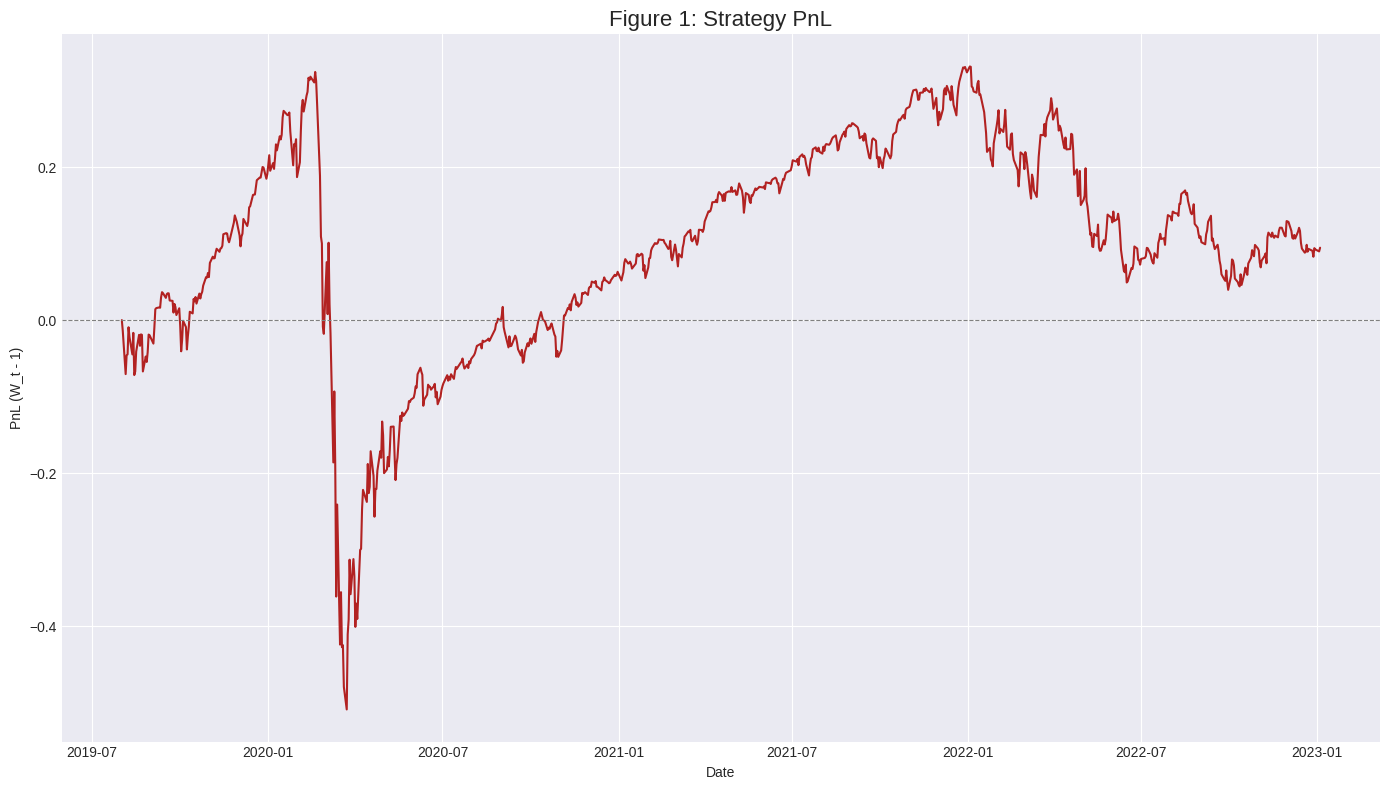

In [14]:
def run_backtest():
  """
  first-version: we use int as index.
  serve as ground truth.
  """
  # parameter setup
  r = 0.01 / 250
  rebalance_period = 1
  lookback = 900
  horizon = 100
  mode = "horizon"
  prices = df['Close']

  # variable init
  portfolio_values = [1.0]
  portfolio_returns = []

  #
  dates = prices.index
  rebalance_date_indice = get_rebalance_date(start_idx=lookback, end_idx=len(prices), rebalance_period=1) # 我这里加了最后一天，但其实最后一天不用rebalance
  # print(rebalance_date_indice)
  # init alpha_series

  # main loop
  # only need to compute return
  for idx in rebalance_date_indice[:-1]:
    today = dates[idx]
    tomorrow = dates[idx+1]
    alpha = alpha_series.loc[today]
    portfolio_return = alpha * (prices.loc[tomorrow] / prices.loc[today] - 1) + (1-alpha) * r
    portfolio_returns.append(portfolio_return)
    portfolio_values.append((portfolio_return+1) * portfolio_values[-1])

  # print(portfolio_values)
  print('Summary of Strategy:')
  print('='*50)
  portfolio_returns = np.array(portfolio_returns)
  portfolio_mu = portfolio_returns.mean() * 250
  portfolio_std = portfolio_returns.std() * np.sqrt(250)
  portfolio_sharpe = (portfolio_mu - r*250) / portfolio_std

  print(f'Porfolio return annualized mean: {portfolio_mu}')
  print(f'Porfolio return annualized mean: {portfolio_std}')
  print(f'Porfolio\'s Sharpe ratio: {portfolio_sharpe}')

  plt.style.use('seaborn-v0_8-darkgrid')
  plt.figure(figsize=(14, 8))

  color = 'firebrick'
  label = 'Vanilla: No transaction costs'
  portfolio_values = np.array(portfolio_values)
  plt.plot(dates[rebalance_date_indice], portfolio_values-1, color, label=label)
  plt.title('Figure 1: Strategy PnL', fontsize=16)
  plt.xlabel('Date')
  plt.ylabel('PnL (W_t - 1)')
  plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

run_backtest()

## b. Adding transaction cost

Summary of Strategy:
Optimal_NoTC_1a - Porfolio return annualized mean: 0.10397693834176223
Optimal_NoTC_1a - Porfolio return annualized mean: 0.3895992872148978
Optimal_NoTC_1a - Porfolio's Sharpe ratio: 0.24121434875707515


Optimal_NoTC_withTC_1b - Porfolio return annualized mean: -0.02863693092624256
Optimal_NoTC_withTC_1b - Porfolio return annualized mean: 0.39373039470634147
Optimal_NoTC_withTC_1b - Porfolio's Sharpe ratio: -0.09813042489406844




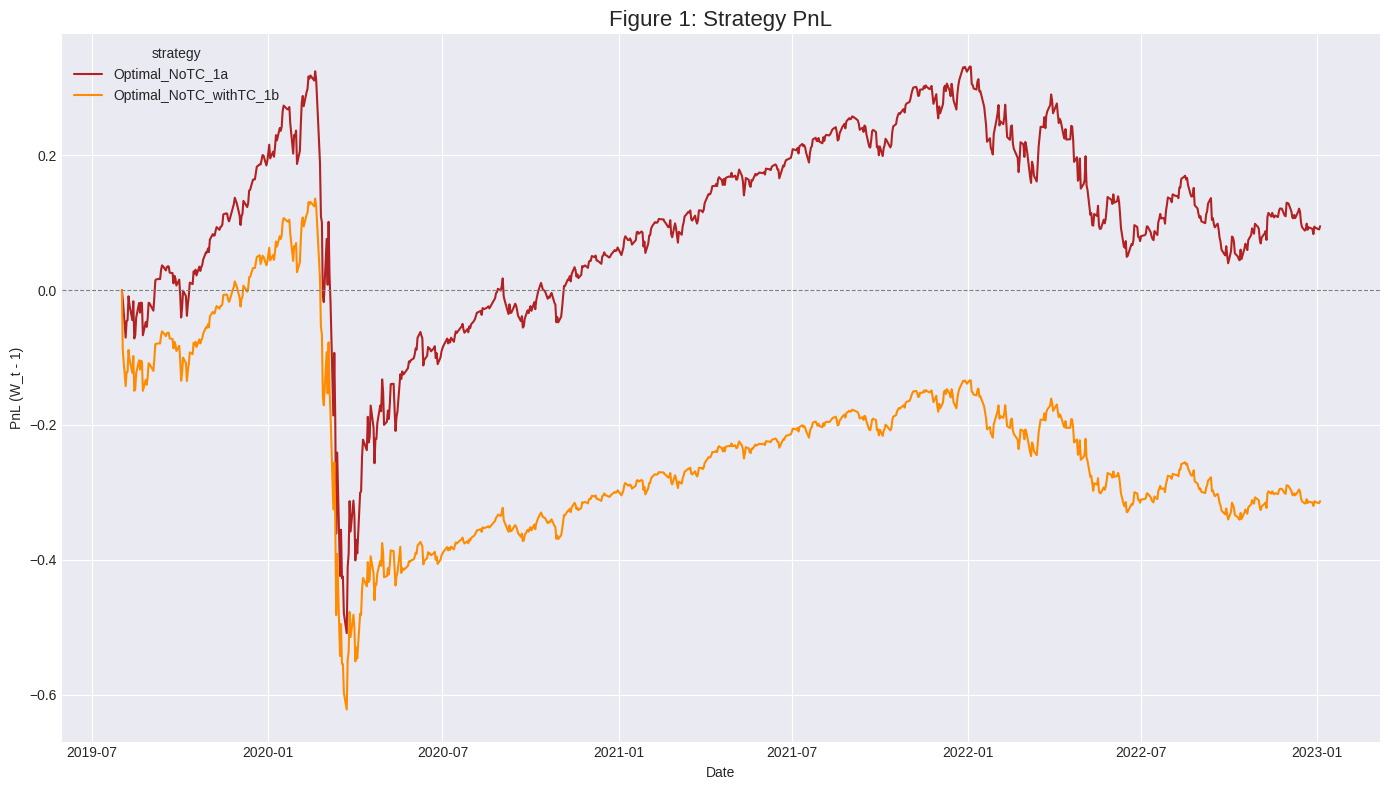

In [42]:
def run_backtest():
  """
  first-version: we use int as index.
  serve as ground truth.
  """
  # parameter setup
  r = 0.01 / 250
  rebalance_period = 1
  lookback = 900
  horizon = 100
  lmbd = 0.02
  mode = "horizon"
  prices = df['Close']

  ###############################################################
  # new init method: we pass strategy as a list into the backtest
  STRATEGIES = [
    'Optimal_NoTC_1a',          # 1(a): Optimal alpha, No TC (Vanilla)
    'Optimal_NoTC_withTC_1b',   # 1(b): Use alpha from 1(a), WITH TC
    # 'DPP_Optimal_withTC_1c'     # 1(c): DPP Optimal alpha, WITH TC
  ]
  portfolio_values = {strategy: [1.0] for strategy in STRATEGIES}
  portfolio_returns = {strategy: [] for strategy in STRATEGIES}

  weights_prime_t = np.array([0.0, 1.0])
  #################################################################
  #
  dates = prices.index
  rebalance_date_indice = get_rebalance_date(start_idx=lookback, end_idx=len(prices), rebalance_period=1) # 我这里加了最后一天，但其实最后一天不用rebalance
  # print(rebalance_date_indice)
  # init alpha_series

  # main loop
  # only need to compute return
  for idx in rebalance_date_indice[:-1]:
    today = dates[idx]
    tomorrow = dates[idx+1]
    alpha = alpha_series.loc[today]
    ################################################################
    for strategy in STRATEGIES:
    ###########################################################################
      returns_tplus1 = np.array([prices.loc[tomorrow] / prices.loc[today] - 1, r])
      weights_t = np.array([alpha, 1-alpha])
      if strategy == 'Optimal_NoTC_1a':
        portfolio_return = np.dot(weights_t, returns_tplus1)
        portfolio_returns[strategy].append(portfolio_return)
        portfolio_values[strategy].append((portfolio_return+1) * portfolio_values[strategy][-1])
      else:
        # print(idx,strategy,alpha)
        weights_prime_tplus1, portfolio_return = compute_weights_tplus1_before_rebalancing(weights_t, returns_tplus1)
        portfolio_return -= lmbd * np.sum(np.abs(weights_t -  weights_prime_t))
        portfolio_returns[strategy].append(portfolio_return)
        portfolio_values[strategy].append((portfolio_return+1) * portfolio_values[strategy][-1])
        weights_prime_t = weights_prime_tplus1

  # print(portfolio_values)
  print('Summary of Strategy:')
  # new stats:
  for strategy in STRATEGIES:
    print('='*50)
    portfolio_return = np.array(portfolio_returns[strategy])
    portfolio_mu = portfolio_return.mean() * 250
    portfolio_std = portfolio_return.std() * np.sqrt(250)
    portfolio_sharpe = (portfolio_mu - r*250) / portfolio_std

    print(f'{strategy} - Porfolio return annualized mean: {portfolio_mu}')
    print(f'{strategy} - Porfolio return annualized mean: {portfolio_std}')
    print(f'{strategy} - Porfolio\'s Sharpe ratio: {portfolio_sharpe}')
    print('\n')

  # draw plot
  plt.style.use('seaborn-v0_8-darkgrid')
  plt.figure(figsize=(14, 8))

  color = {
      'Optimal_NoTC_1a':'firebrick',
      'Optimal_NoTC_withTC_1b':'darkorange',
  }
  for strategy in STRATEGIES:
    portfolio_value = np.array(portfolio_values[strategy])
    plt.plot(dates[rebalance_date_indice], portfolio_value-1, color[strategy], label=strategy)
  plt.title('Figure 1: Strategy PnL', fontsize=16)
  plt.xlabel('Date')
  plt.ylabel('PnL (W_t - 1)')
  plt.legend(title='strategy', loc='upper left', fontsize=10)
  plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

run_backtest()

## c. optimize with transaction costs

In [52]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

def negative_expected_utility(alpha, v_fun, a, mu, sigma, r, lmbd, zeta):
  weights_t = np.array([alpha, 1-alpha])

  sums = 0
  for i in [1, -1]:
    returns_tplus1 = np.array([mu+i*sigma, r])
    weights_prime_tplus1, portfoliio_return = compute_weights_tplus1_before_rebalancing(weights_t, returns_tplus1)
    portfoliio_return -= 2 * lmbd * np.sum(np.abs(weights_t[0] -  a))
    sums += v_fun(weights_prime_tplus1[0])  * ((1+portfoliio_return) ** zeta)
  return -sums

def generate_v_table(
    r, mu, sigma, T=100, zeta=-3, a_min=-1, a_max=2.5, n_grid=100, lmbd=0.02
)->List[Any]:
  """
  Return [alpha_star_0(a), alpha_star_1(a), alpha_star_T-1(a)]
  """
  a_grid = np.linspace(a_min, a_max, n_grid)
  v_grid_value = np.array([1/zeta] * n_grid)
  v_fun = interp1d(
      a_grid, v_grid_value,
      kind='linear',
      fill_value=(v_grid_value[0], v_grid_value[-1]), # 使用第一个点和最后一个点的值进行常数外推
      bounds_error=False         # 允许在 x 范围外调用
  )
  reverse_v_funs = [v_fun]

  bounds = (-5.0, 5.0)
  for t in range(T-1, -1, -1):
    v_grid_value = []
    for a in a_grid:
      # 求解最优 alpha*
      res = minimize_scalar(
          negative_expected_utility,
          args=(v_fun, a, mu, sigma, r, lmbd, zeta),
          bounds=bounds,
          method='bounded'
      )
      # 最优策略 alpha*
      v_star = -res.fun
      v_grid_value.append(v_star)

    v_fun = interp1d(
      a_grid, v_grid_value,
      kind='linear',
      fill_value=(v_grid_value[0], v_grid_value[-1]), # 使用第一个点和最后一个点的值进行常数外推
      bounds_error=False         # 允许在 x 范围外调用
    )
    reverse_v_funs.append(v_fun)

  v_funs = reverse_v_funs[::-1]
  return v_funs


Summary of Strategy:
Optimal_NoTC_withTC_1b - Porfolio return annualized mean: -0.02863693092624256
Optimal_NoTC_withTC_1b - Porfolio return annualized mean: 0.39373039470634147
Optimal_NoTC_withTC_1b - Porfolio's Sharpe ratio: -0.09813042489406844


DPP_Optimal_withTC_1c - Porfolio return annualized mean: 0.05742123146576618
DPP_Optimal_withTC_1c - Porfolio return annualized mean: 0.1395318445738215
DPP_Optimal_withTC_1c - Porfolio's Sharpe ratio: 0.33985956116761024




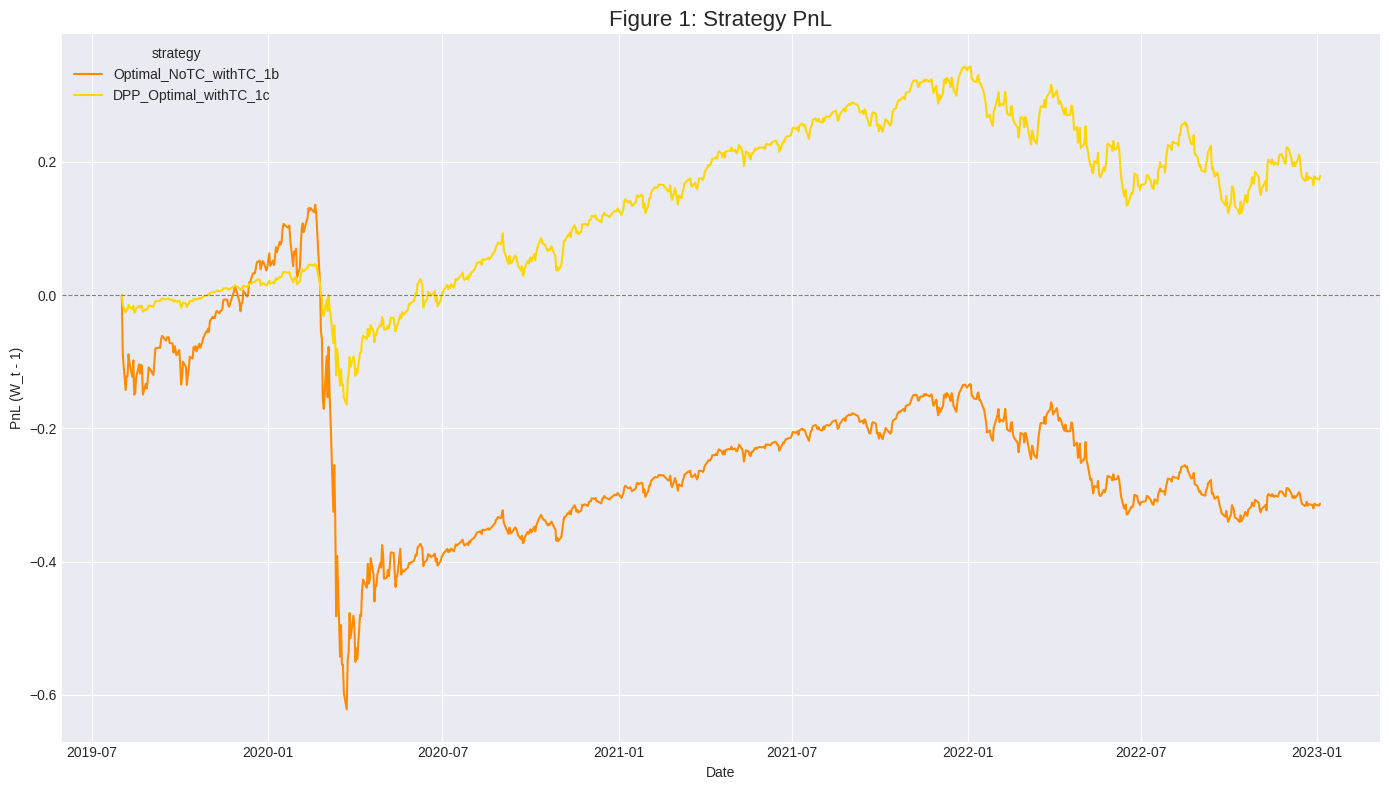

In [53]:
def run_backtest():
  """
  first-version: we use int as index.
  serve as ground truth.
  """
  # parameter setup
  r = 0.01 / 250
  rebalance_period = 1
  lookback = 900
  horizon = 100
  lmbd = 0.02
  zeta = -3
  bounds = (-5.0, 5.0)
  mode = "horizon"
  prices = df['Close']

  ###############################################################
  # new init method: we pass strategy as a list into the backtest
  STRATEGIES = [
    # 'Optimal_NoTC_1a',          # 1(a): Optimal alpha, No TC (Vanilla)
    'Optimal_NoTC_withTC_1b',   # 1(b): Use alpha from 1(a), WITH TC
    'DPP_Optimal_withTC_1c'     # 1(c): DPP Optimal alpha, WITH TC
  ]
  portfolio_values = {strategy: [1.0] for strategy in STRATEGIES}
  portfolio_returns = {strategy: [] for strategy in STRATEGIES}

  weights_prime_t = {strategy: np.array([0.0, 1.0]) for strategy in STRATEGIES}
  #################################################################
  #
  dates = prices.index
  rebalance_date_indice = get_rebalance_date(start_idx=lookback, end_idx=len(prices), rebalance_period=1) # 我这里加了最后一天，但其实最后一天不用rebalance
  # print(rebalance_date_indice)
  # init alpha_series

  # main loop
  # only need to compute return
  for i, idx in enumerate(rebalance_date_indice[:-1]):
    t_in_horizon = (idx-lookback) % horizon
    if t_in_horizon == 0:
      mu = result_df.loc[dates[idx]]['Rolling_Mean']
      std = result_df.loc[dates[idx]]['Rolling_Std']
      actual_horizon = min(horizon, len(dates) - idx)
      v_funs = generate_v_table(r, mu, std, T=actual_horizon, lmbd=lmbd)
      # print(len(v_funs))
    today = dates[idx]
    tomorrow = dates[idx+1]
    for strategy in STRATEGIES:
      if strategy == 'Optimal_NoTC_withTC_1b':
        alpha = alpha_series.loc[today]
        # print(idx,strategy,alpha)
      elif strategy == 'DPP_Optimal_withTC_1c':
        v_fun = v_funs[t_in_horizon]
        res = minimize_scalar(
          negative_expected_utility,
          args=(v_fun, weights_prime_t[strategy][0], mu, std, r, lmbd, zeta),
          bounds=bounds,
          method='bounded'
        )
        alpha = res.x

      returns_tplus1 = np.array([prices.loc[tomorrow] / prices.loc[today] - 1, r])
      weights_t = np.array([alpha, 1-alpha])
      weights_prime_tplus1, portfolio_return = compute_weights_tplus1_before_rebalancing(weights_t, returns_tplus1)
      portfolio_return -= lmbd * np.sum(np.abs(weights_t -  weights_prime_t[strategy]))
      portfolio_returns[strategy].append(portfolio_return)
      portfolio_values[strategy].append((portfolio_return+1) * portfolio_values[strategy][-1])
      weights_prime_t[strategy] = weights_prime_tplus1

  # print(portfolio_values)
  print('Summary of Strategy:')
  ################################################################
  # new stats:
  for strategy in STRATEGIES:
    print('='*50)
    portfolio_return = np.array(portfolio_returns[strategy])
    portfolio_mu = portfolio_return.mean() * 250
    portfolio_std = portfolio_return.std() * np.sqrt(250)
    portfolio_sharpe = (portfolio_mu - r*250) / portfolio_std

    print(f'{strategy} - Porfolio return annualized mean: {portfolio_mu}')
    print(f'{strategy} - Porfolio return annualized mean: {portfolio_std}')
    print(f'{strategy} - Porfolio\'s Sharpe ratio: {portfolio_sharpe}')
    print('\n')
  ###########################################################################
  plt.style.use('seaborn-v0_8-darkgrid')
  plt.figure(figsize=(14, 8))

  color = {
      # 'Optimal_NoTC_1a':'firebrick',
      'Optimal_NoTC_withTC_1b':'darkorange',
      'DPP_Optimal_withTC_1c':'gold'
  }
  for strategy in STRATEGIES:
    portfolio_value = np.array(portfolio_values[strategy])
    plt.plot(dates[rebalance_date_indice], portfolio_value-1, color[strategy], label=strategy)
  plt.title('Figure 1: Strategy PnL', fontsize=16)
  plt.xlabel('Date')
  plt.ylabel('PnL (W_t - 1)')
  plt.legend(title='strategy', loc='upper left', fontsize=10)
  plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  return portfolio_values, portfolio_returns

portfolio_values, portfolio_returns = run_backtest()

{'Optimal_NoTC_withTC_1b': [np.float64(-0.09014004745708641),
  np.float64(-0.057568588244224665),
  np.float64(0.02437857500352013),
  np.float64(0.00015869212120954044),
  np.float64(0.03712257838661596),
  np.float64(-0.014231829528149822),
  np.float64(-0.023584873450146017),
  np.float64(0.02859712240420074),
  np.float64(-0.05711202165774746),
  np.float64(0.0028416705111534045),
  np.float64(0.027759853941855796),
  np.float64(0.02183215014464355),
  np.float64(-0.015360222462329168),
  np.float64(0.014856363442890385),
  np.float64(-0.0011610677922323821),
  np.float64(-0.04875697348746506),
  np.float64(0.01909150621259032),
  np.float64(-0.008207132991347166),
  np.float64(0.013041991947845322),
  np.float64(0.0237092859050503),
  np.float64(-0.001722409706656114),
  np.float64(-0.011153736703077894),
  np.float64(0.021077196334678538),
  np.float64(0.02358336321425374),
  np.float64(0.0005775070625493406),
  np.float64(0.0008691123683492763),
  np.float64(-0.0005120509428978